In [1]:
# Datenzugriff
from configs.path_manager import get_path
import pickle

# Utils
from src.utils.production_process.rolling_filter import *
import src.utils.presenter as show

# Solver Model
from src.models.cp import lateness_scheduling as cp_late_schedule

# Simulation
from src.simulation.ProductionRollingSimulation import ProductionSimulation

# Extern
import pandas as pd

pd.set_option('display.min_rows', 12)
pd.set_option('display.max_rows', 16)

In [2]:
# Harte Abbruchbedingung für die Scheduler
max_time = 60*30     # 30 min

# Simulation
simulation = ProductionSimulation(sigma = 0.15)

## I. Laden des fertigen Job-Shop Scheduling Problems und der dazugehörigen Produktionsauftragsinformationen

In [3]:
basic_data_path = get_path("data", "basic")
experiments_data_path = get_path("data", "experiments")
df_jssp = pd.read_csv(basic_data_path / "jssp_final.csv")
df_jssp

,Job,Routing_ID,Operation,Machine,Processing Time
0,J25-0000,8,0,M00,76
1,J25-0000,8,1,M01,69
2,J25-0000,8,2,M03,76
3,J25-0000,8,3,M05,51
4,J25-0000,8,4,M02,85
5,J25-0000,8,5,M09,11
...,...,...,...,...,...
72494,J25-7249,4,4,M03,26
72495,J25-7249,4,5,M04,69
72496,J25-7249,4,6,M08,21


In [4]:
df_jobs_times = pd.read_csv(basic_data_path / "jobs_times_final.csv")
df_jobs_times

,Job,Routing_ID,Arrival,Ready Time,End,Processing Time,Deadline
0,J25-0000,8,79,1440,2704.0,597,3660
1,J25-0001,6,129,1440,2336.0,416,2338
2,J25-0002,0,198,1440,2925.0,395,3744
3,J25-0003,2,243,1440,2801.0,568,3379
4,J25-0004,3,287,1440,2697.0,655,4856
5,J25-0005,1,498,1440,2630.0,510,3106
...,...,...,...,...,...,...,...
7244,J25-7244,3,518085,518400,520251.0,655,520389
7245,J25-7245,9,518089,518400,520296.0,540,519640
7246,J25-7246,6,518116,518400,520027.0,416,520157


## Tag 1
- Am Tag 0 kommen die ersten Produktionsaufträge an, somit kann noch nichts geplant werden
- Am Tag 1 findet die initiale Planung statt

In [5]:
day_length = 1440

day_numb = 1
day_start = day_length*day_numb
day_end = day_start + day_length
print(f"Tag {day_numb:02d}: [{day_start}, {day_end})")

Tag 01: [1440, 2880)


In [6]:
# "neue" und unerledigte Jobs
df_jobs_times_current = get_current_jobs(
    df_jobs_times, df_previous_not_started = None, ready_time=day_start
)
df_jobs_times_current

,Job,Routing_ID,Arrival,Ready Time,End,Processing Time,Deadline
0,J25-0000,8,79,1440,2704.0,597,3660
1,J25-0001,6,129,1440,2336.0,416,2338
2,J25-0002,0,198,1440,2925.0,395,3744
3,J25-0003,2,243,1440,2801.0,568,3379
4,J25-0004,3,287,1440,2697.0,655,4856
5,J25-0005,1,498,1440,2630.0,510,3106
6,J25-0006,9,790,1440,2905.0,540,3539
7,J25-0007,5,925,1440,2930.0,496,2929
8,J25-0008,4,988,1440,2986.0,393,3541
9,J25-0009,7,1004,1440,3045.0,539,3578


In [7]:
df_jssp_current = filter_current_jssp(df_jssp, df_jobs_times_current)
df_jssp_current

,Job,Routing_ID,Operation,Machine,Processing Time
0,J25-0000,8,0,M00,76
1,J25-0000,8,1,M01,69
2,J25-0000,8,2,M03,76
3,J25-0000,8,3,M05,51
4,J25-0000,8,4,M02,85
5,J25-0000,8,5,M09,11
...,...,...,...,...,...
154,J25-0015,5,4,M08,48
155,J25-0015,5,5,M09,72
156,J25-0015,5,6,M00,47


### Scheduling

In [8]:
# Scheduling
df_schedule = cp_late_schedule.solve_jssp_sum_by_tardiness_and_earliness(
    df_jssp_current, df_jobs_times_current, earliest_start_column = "Ready Time", w_t= 5,
    msg=False, timeLimit=max_time, gapRel=0.01)
df_schedule


Solver-Status         : OPTIMAL
Objective Value       : 0.00
Best Objective Bound  : 0.00
Laufzeit              : 0.03 Sekunden


,Job,Routing_ID,Arrival,Ready Time,Deadline,Operation,Machine,Start,Processing Time,End
0,J25-0005,1,498,1440,3106,0,M00,1440,43,1483
1,J25-0007,5,925,1440,2929,0,M02,1440,84,1524
2,J25-0013,3,1192,1440,2567,0,M01,1440,81,1521
3,J25-0011,1,1030,1440,3210,0,M00,1483,43,1526
4,J25-0001,6,129,1440,2338,0,M01,1521,46,1567
5,J25-0013,3,1192,1440,2567,1,M02,1524,95,1619
...,...,...,...,...,...,...,...,...,...,...
154,J25-0006,9,790,1440,3539,9,M07,3494,45,3539
155,J25-0009,7,1004,1440,3578,9,M03,3499,79,3578
156,J25-0000,8,79,1440,3660,9,M08,3586,74,3660


In [9]:
df_schedule.to_csv(experiments_data_path / "CP_01_schedule.csv", index=False)

### Simulation

In [10]:
simulation.run(dframe_schedule_plan = df_schedule, start_time = day_start, end_time=day_end)

[Day 1 00:00:00] Job J25-0005 started on M00
[Day 1 00:00:00] Job J25-0007 started on M02
[Day 1 00:00:00] Job J25-0013 started on M01
[Day 1 00:46:00] Job J25-0005 finished on M00 (after 46 minutes)
[Day 1 00:46:00] Job J25-0011 started on M00
[Day 1 01:20:00] Job J25-0013 finished on M01 (after 80 minutes)
[Day 1 01:21:00] Job J25-0001 started on M01
[Day 1 01:25:00] Job J25-0007 finished on M02 (after 85 minutes)
[Day 1 01:25:00] Job J25-0013 started on M02
[Day 1 01:42:00] Job J25-0011 finished on M00 (after 56 minutes)
[Day 1 01:42:00] Job J25-0010 started on M00
[Day 1 02:11:00] Job J25-0010 finished on M00 (after 29 minutes)
[Day 1 02:11:00] Job J25-0000 started on M00
[Day 1 02:16:00] Job J25-0001 finished on M01 (after 55 minutes)
[Day 1 02:16:00] Job J25-0007 started on M01
[Day 1 02:18:00] Job J25-0007 finished on M01 (after 02 minutes)
[Day 1 02:18:00] Job J25-0003 started on M01
[Day 1 02:18:00] Job J25-0007 started on M05
[Day 1 02:34:00] Job J25-0013 finished on M02 (aft

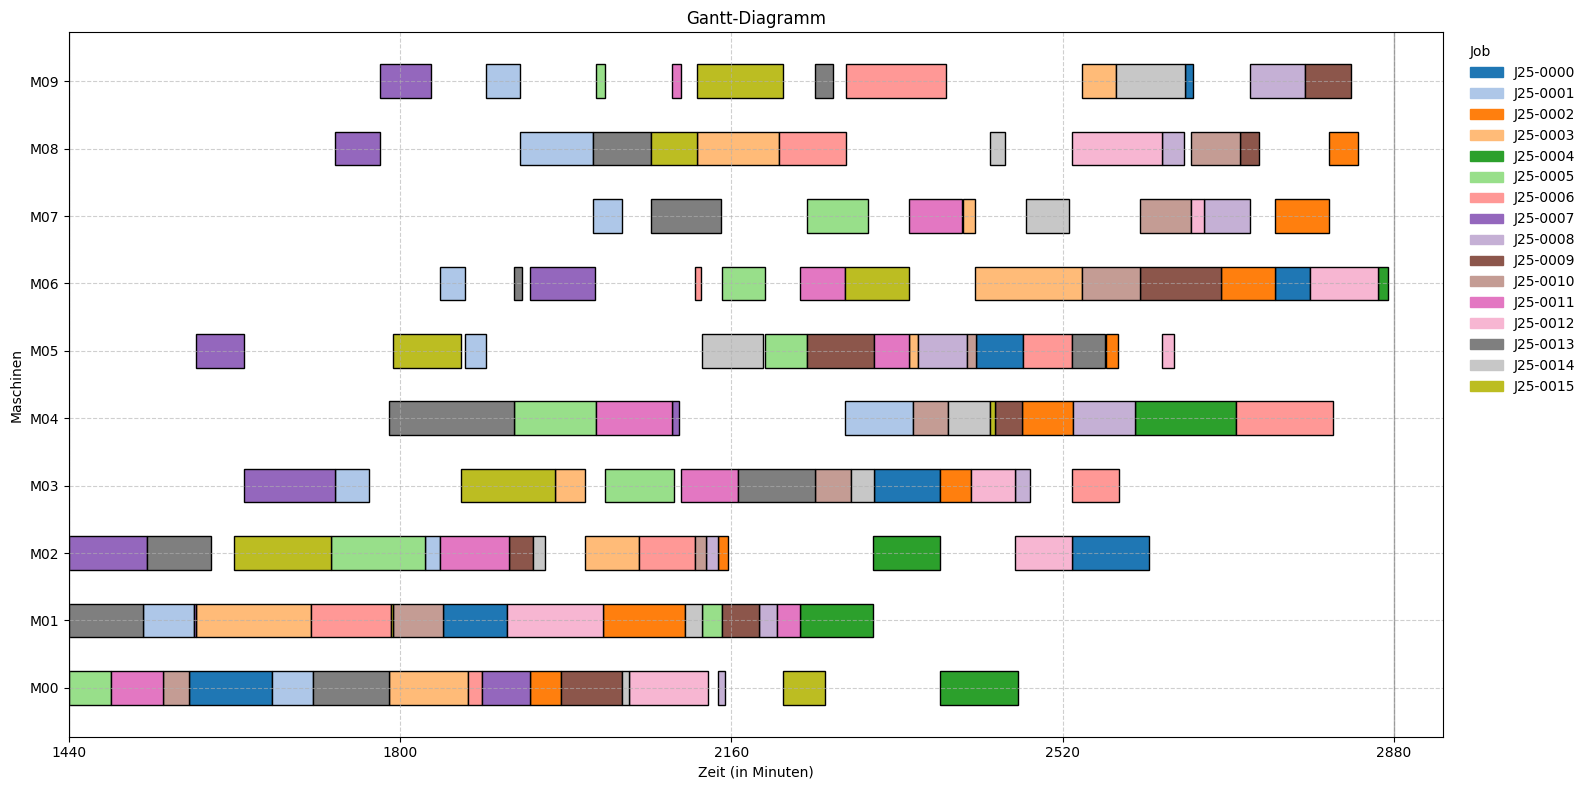

In [11]:
df_execution = simulation.get_finished_operations_df()
show.plot_gantt(df_execution, perspective="Machine")
df_execution .to_csv(experiments_data_path / "CP_01_execution.csv", index=False)

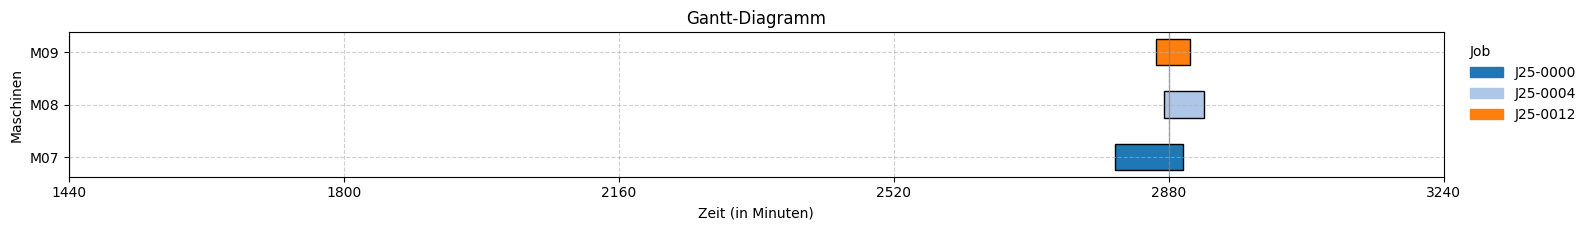

In [12]:
df_active = simulation.get_active_operations_df()
if df_active is not None:
    show.plot_gantt(df_active, perspective="Machine", duration_column="Planned Duration")

df_active.to_csv(experiments_data_path / "CP_01_active.csv", index=False)

In [13]:
active_dict = simulation.get_active_operations()

with open(experiments_data_path / "CP_01_active_dict.pkl", "wb") as f:
    pickle.dump(active_dict, f)

In [15]:
df_not_started = simulation.get_not_started_operations_df(df_schedule)
df_not_started.to_csv(experiments_data_path / "CP_01_not_started.csv", index=False)
df_not_started

,Job,Routing_ID,Arrival,Ready Time,Deadline,Operation,Machine,Start,Processing Time,End
0,J25-0000,8,79,1440,3660,8,M04,2808,26,2834
1,J25-0000,8,79,1440,3660,9,M08,3586,74,3660
2,J25-0002,0,198,1440,3744,9,M09,3723,21,3744
3,J25-0003,2,243,1440,3379,9,M04,3346,33,3379
4,J25-0004,3,287,1440,4856,6,M07,2981,85,3066
5,J25-0004,3,287,1440,4856,7,M03,3066,98,3164
...,...,...,...,...,...,...,...,...,...,...
13,J25-0009,7,1004,1440,3578,9,M03,3499,79,3578
14,J25-0010,0,1025,1440,3345,9,M09,3324,21,3345
15,J25-0011,1,1030,1440,3210,9,M08,3180,30,3210
